# Ipython notebook for omstilling website

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import pystan
import scipy
from ggplot import *
import math
import re
import json
from datetime import datetime
%matplotlib inline
from pandas.io.json import json_normalize
pd.options.mode.chained_assignment = None 

### Plot settings:

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams["axes.labelsize"]= 20
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 18
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.color_cycle"] = multi

## Functions

In [3]:
#show categories in a json file
def show_categories(json_data):
	print(json_data["dataset"]["dimension"]["ContentsCode"])


#convert to datetime
def convert_datetime(date_series):
	if "K" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("K",""))
		month = [str(int(t[-1])*3) for t in time]
		year = [str(int(t[:-1])) for t in time]
		new_date_series = [x+y for x,y in zip(year, month)]
		new_date_series = pd.to_datetime(new_date_series, format='%Y%m')
	if "M" in date_series[0]:
		time = date_series.apply(lambda x: x.replace("M",""))
		new_date_series = pd.to_datetime(time, format='%Y%m')
		return(new_date_series)
    
#convert month-date format:
yearmonth = lambda x: datetime.strptime(x, '%Y%m')

#smooth a series using lowess
def smooth_series(srs):
	x_range = [i for i in range(len(srs))]
	smoothed = sm.nonparametric.lowess(srs,x_range, frac=0.1)
	return(pd.Series(smoothed[:,1]))

# Employment

In [4]:

employment_json = pd.read_json("https://data.ssb.no/api/v0/dataset/1054.json?lang=en")

age_labels = employment_json["dataset"]["dimension"]["Alder"]
sex_labels = employment_json["dataset"]["dimension"]["Kjonn"]
content_labels = employment_json["dataset"]["dimension"]["ContentsCode"]


In [5]:
employment = pd.read_csv("https://data.ssb.no/api/v0/dataset/1054.csv?lang=en")

employment.columns = ["sex", "age", "contents", "time", "value"]

unemp_1000 = employment[employment.contents == 'Unemployment (LFS) (1 000 persons), seasonally adjusted']
#unemp_1000 = unemp_1000[unemp_1000.sex=="0 Both sexes"]
unemp_1000 = unemp_1000[unemp_1000.age=="25-74 25-74 years"]
unemp_1000 = unemp_1000[["time", "sex", "value"]]

unemp_1000["time"] = unemp_1000.time.apply(lambda x:  x.replace("M", ""))
unemp_1000["time"] = pd.to_datetime(unemp_1000["time"], format="%Y%m")

unemp_1000["value"][unemp_1000.value == ".."] = np.nan
unemp_1000["value"] = unemp_1000.value.astype(float)

unemp_1000.columns =["date", "sex", "value"]
unemp_1000["sex"] = unemp_1000.sex.apply(lambda x: x[2:])


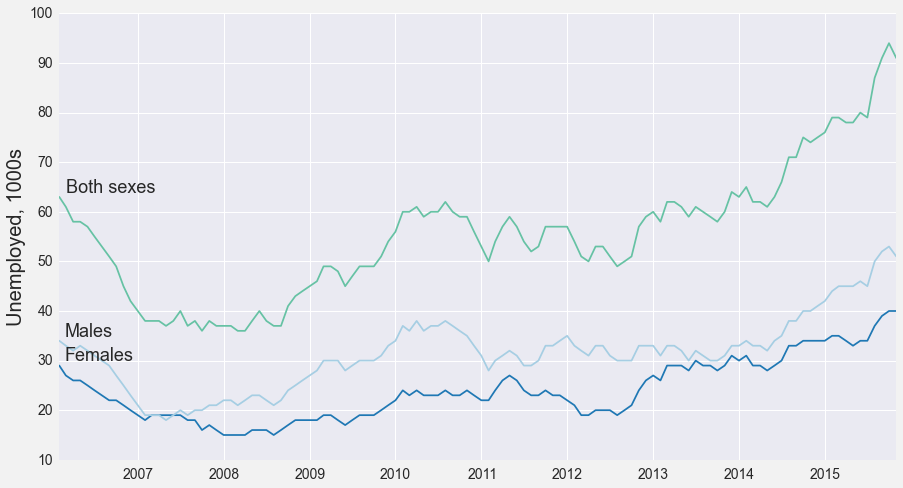

In [6]:
fig, ax = plt.subplots()
start = datetime.strptime('01032006', '%d%m%Y')
unemp_by_sex = unemp_1000.groupby("sex")
for unemp in unemp_by_sex:
	ax.plot(unemp[1].date, unemp[1].value, label=unemp[0])
	ax.annotate(unemp[0], xy=(start, np.array(unemp[1].value)[0]+1))
ax.set_ylabel("Unemployed, 1000s")
#ax.set_xlim(datetime.strptime('01012016', '%d%m%Y'))
fig.set_size_inches(15,8)
fig.savefig("figures/unemployment.png")
plt.show()

In [7]:
emp_perc_sa = employment[employment.contents == "Employed persons in per cent of the population, seasonally adjusted"].copy()
emp_perc_sa.is_copy = False

emp_perc_sa = emp_perc_sa[emp_perc_sa.age=="25-74 25-74 years"]
emp_perc_sa = emp_perc_sa[["time", "sex", "value"]]

emp_perc_sa.loc[:,"time"] = emp_perc_sa.time.apply(lambda x:  x.replace("M", ""))
emp_perc_sa.loc[:,"time"] = pd.to_datetime(emp_perc_sa["time"], format="%Y%m")

emp_perc_sa.loc[:,"value"][emp_perc_sa.value == ".."] =np.nan
emp_perc_sa.loc[:,"value"] = emp_perc_sa.value.astype(float)

emp_perc_sa.columns =["date", "sex", "value"]
emp_perc_sa.loc[:,"sex"] = emp_perc_sa.sex.apply(lambda x: x[2:])

emp_perc_sa.set_index("date", inplace=True)
emp_perc_sa.reset_index(inplace=True)

start = datetime.strptime('01012008', '%d%m%Y')



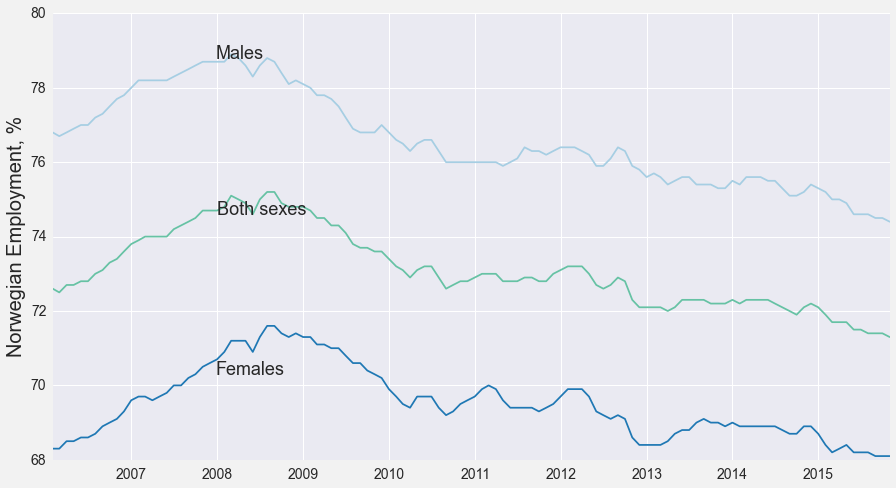

In [8]:
fig, ax = plt.subplots()
emp_by_sex = emp_perc_sa.groupby("sex")
for emp in emp_by_sex:
	ax.plot(emp[1].date, emp[1].value, label=emp[0])
	ax.annotate(emp[0], xy=(start, np.array(emp[1].value)[0]+2))
ax.set_ylabel("Norwegian Employment, %")
fig.set_size_inches(15,8)
fig.savefig("figures/employment.png", bbox_inches='tight')
plt.show()

### Bankruptcies

In [11]:
bankruptcies = pd.read_csv("https://data.ssb.no/api/v0/dataset/95265.csv?lang=en")

enter_bank = bankruptcies[bankruptcies.contents == 'Bankruptcies related to enterprises (excl. sole propriertorships)']
pers_bank = bankruptcies[bankruptcies.contents == 'Personal bankruptcies (incl. sole propriertorships)']

def format_df(df):
	df.columns = ["time", "contents", "value"]
	df = df[["time", "value"]]
	df.loc[:, "time"] = df.time.apply(lambda x:  x.replace("M", ""))
	df.loc[:, "time"] = pd.to_datetime(df["time"], format="%Y%m")
	df.loc[:, "value"][df.value == ".."] =np.nan
	df.loc[:, "value"] = df.value.astype(float)
	return(df)

enter_bank = format_df(enter_bank)
pers_bank = format_df(pers_bank)

start = datetime.strptime('01012000', '%d%m%Y')




/Users/johannesmauritzen/anaconda/lib/python3.4/site-packages/pandas/core/ops.py:680: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [10]:
from scipy.interpolate import UnivariateSpline

enter_bank = enter_bank[enter_bank.value.notnull()]
pers_bank = pers_bank[pers_bank.value.notnull()]

t = len(enter_bank.time)
T = [i for i in range(t)]
s_enter = UnivariateSpline(T, enter_bank.value, k=3, s=400000)
smooth_enter = s_enter(T)
s_pers = UnivariateSpline(T, pers_bank.value, k=3, s=200000)
smooth_person = s_pers(T)

AttributeError: 'DataFrame' object has no attribute 'value'

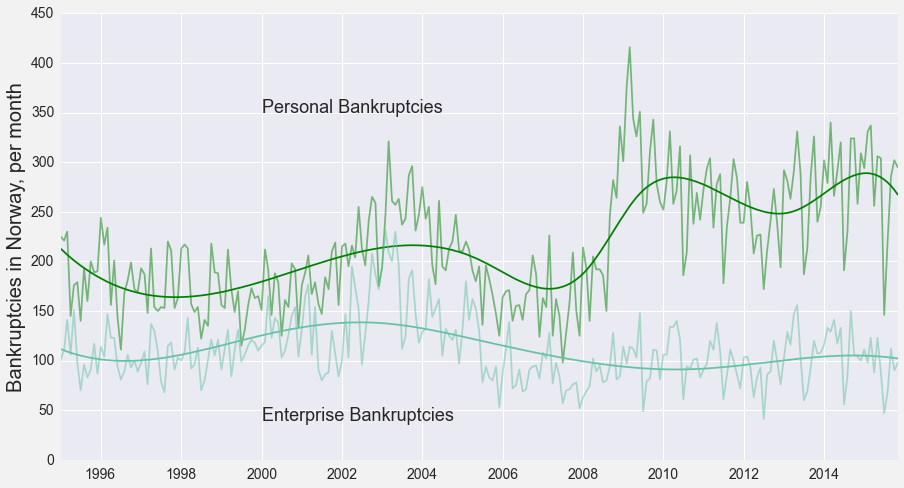

In [11]:
fig, ax = plt.subplots()
ax.plot(enter_bank.time, enter_bank.value, color="green", alpha=.5)
ax.plot(enter_bank.time, smooth_enter, color="green")
ax.plot(pers_bank.time, pers_bank.value, color='#66c2a4', alpha=.5)
ax.plot(pers_bank.time, smooth_person, color='#66c2a4')
ax.annotate('Personal Bankruptcies', xy=(start, 350))
ax.annotate('Enterprise Bankruptcies', xy=(start, 40))
ax.set_ylabel("Bankruptcies in Norway, per month")
fig.set_size_inches(15,8)
fig.savefig("figures/bank_plot.png", bbox_inches='tight')
plt.show()

# Housing Prices

In [12]:
house_prices = pd.read_csv("https://data.ssb.no/api/v0/dataset/1060.csv?lang=no", sep=";", header=0)
house_prices.columns = ['region', 'type', 'time', 'variable','value']
time = house_prices.time.apply(lambda x: x.replace("K",""))
month = [str(int(t[-1])*3) for t in time]
year = [str(int(t[:-1])) for t in time]
house_prices["time"] = [x+y for x,y in zip(year, month)]
house_prices["time"] = pd.to_datetime(house_prices.time, format='%Y%m')
na_values = ["..", "."]
house_prices = house_prices[~house_prices.value.isin(na_values)]
house_prices["value"] = house_prices.value.apply(lambda x: float(x.replace(",", ".")))

all_houses = house_prices[house_prices.type=="00 Boliger i alt"]

start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
all_houses = all_houses[all_houses.time>=start]


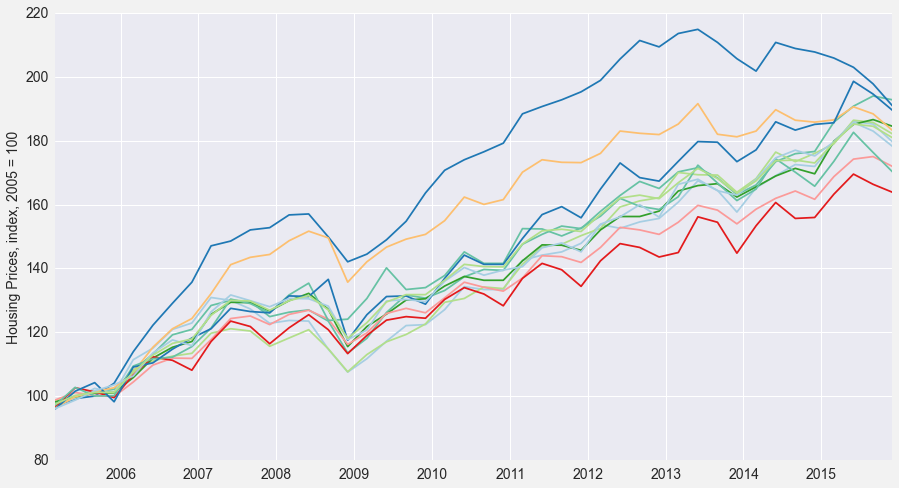

In [13]:
fig, ax = plt.subplots()
houses_by_region= all_houses.groupby("region")
for region in houses_by_region:
	ax.plot(region[1].time, region[1].value, label=region[0])
	#ax.legend()
	#n = len(region[1].value)
	#ax.annotate(region[0], xy=(end, region[1].value[0]) )
ax.set_ylabel("Housing Prices, index, 2005 = 100", size=14)
fig.set_size_inches(15,8)
fig.savefig("figures/housing_prices.png", bbox_inches='tight')
plt.show()

In [14]:
names = []
prices_by_region = house_prices.groupby("region")
for region in prices_by_region:
	names.append(region[0])

new_names = ["Oslo with Baerum", "Stavanger", "Bergen", 
"Trondheim", "Akershus", "Southeast", "Hedmark and Oppland",
"Agder and Rogaland", "Westcoast", "Troendelag", "Northern Norway",
"Total"]

names_dict = dict(zip(names,new_names))

house_prices["region"] = house_prices.region.apply(lambda x: names_dict[x])

cities = new_names[0:4]

house_prices_cities = house_prices[house_prices.region.isin(cities)]
total_cities = house_prices_cities[house_prices_cities.type == "00 Boliger i alt"]


In [15]:
start = datetime.strptime('01012005', '%d%m%Y')
end = datetime.strptime('01012015', '%d%m%Y')
total_cities = total_cities[total_cities.time>=start]


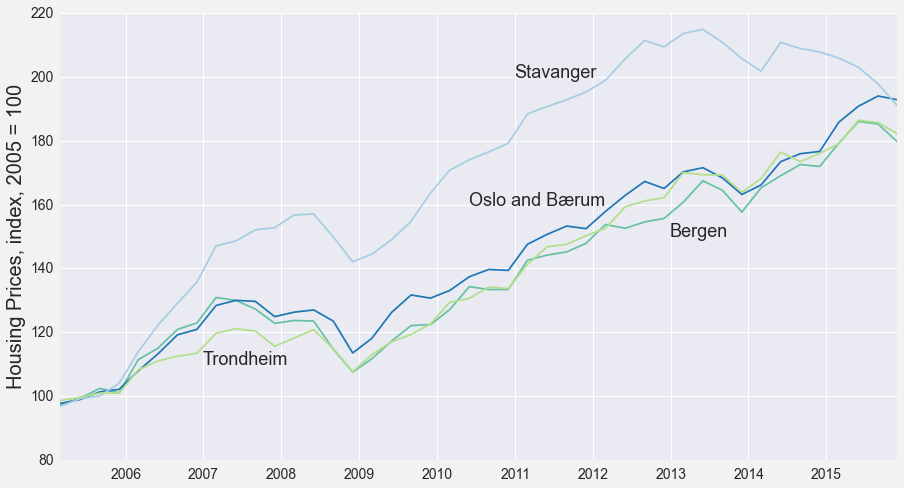

In [16]:
fig, ax = plt.subplots()
houses_by_city= total_cities.groupby("region")
for city in houses_by_city:
	ax.plot(city[1].time, city[1].value, label=city[0])
	#ax.legend()
	#n = len(region[1].value)
ax.annotate("Trondheim", xy=(datetime.strptime('01012007', '%d%m%Y'),110))
ax.annotate("Bergen", xy=(datetime.strptime('01012013', '%d%m%Y'),150))
ax.annotate("Stavanger", xy=(datetime.strptime('01012011', '%d%m%Y'),200))
ax.annotate("Oslo and Bærum", xy=(datetime.strptime('01062010', '%d%m%Y'),160))

ax.set_ylabel("Housing Prices, index, 2005 = 100")
fig.set_size_inches(15,8)
fig.savefig("figures/city_housing_prices.png", bbox_inches='tight')
plt.show()

In [17]:
xls_housing = pd.ExcelFile("http://www.norges-bank.no/Upload/HMS/house_price_index/p1c9.xlsx")
house_prices_l = xls_housing.parse('Table_A1', header=2)
house_prices_l.columns = ["year", "total", "oslo", "bergen", "trondheim", "kristiansand"]
house_prices_l = house_prices_l.iloc[:-15,:]

house_prices_melt = pd.melt(house_prices_l, id_vars="year")
house_prices_melt["value"][house_prices_melt.value==" "] = np.nan
house_prices_melt["value"] =house_prices_melt.value.astype(float)



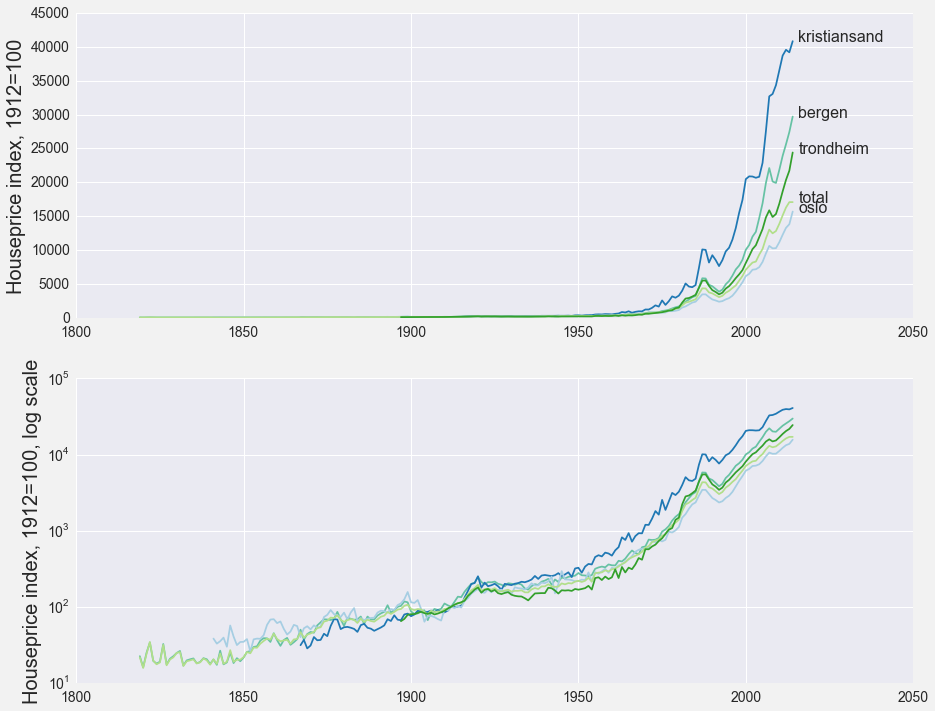

In [18]:
fig, ax = plt.subplots(2)
hp_by_city = house_prices_melt.groupby("variable")

for city_price in hp_by_city:
	ax[0].plot(city_price[1].year, city_price[1].value, label=city_price[0])
	ax[0].text(2016, np.array(city_price[1].value)[-2], city_price[0], size=16)
#ax.legend()
ax[0].set_ylabel("Houseprice index, 1912=100")

for city_price in hp_by_city:
	ax[1].plot(city_price[1].year, city_price[1].value, label=city_price[0])
ax[1].set_ylabel("Houseprice index, 1912=100, log scale")
ax[1].set_yscale('log')

fig.set_size_inches(15, 12)
fig.savefig("figures/houseprices_long.png")
plt.show()

## Credit and Debt

In [19]:
#credit
debt_json = pd.read_json("https://data.ssb.no/api/v0/dataset/62264.json?lang=no")

debt = pd.read_csv("https://data.ssb.no/api/v0/dataset/62264.csv?lang=no", sep=";")
debt.columns = ['currency', 'sector', 'credit_source', 'time', 'variable','value']

debt["time"] = convert_datetime(debt.time)
debt["value"][debt.value == ".."] = np.nan
debt["value"] = debt.value.astype(float)
debt["value"] = debt["value"]/1000

by_source = debt.groupby("credit_source")
for source in by_source:
	print(source[0])

by_sector = debt.groupby("sector")
for sect in by_sector:
	print(sect[0])

total_sources = debt[debt.credit_source=="LTOT Kredittkilder i alt"]
total_sources = total_sources[total_sources.currency=="00 I alt"]




L201 Statlige l�neinstitutter
L202 Banker
L203 Kredittforetak
L204 Finansieringsselskaper
L206 Livsforsikringsselskaper
L207 Skadeforsikringsselskaper
L209 Pensjonskasser
L210 Obligasjonsgjeld
L211 Sertifikatgjeld
L212 Andre kilder
LTOT Kredittkilder i alt
Kred01 Publikum
Kred02 Kommuneforvaltningen
Kred03 Ikke-finansielle foretak
Kred04 Husholdninger mv.


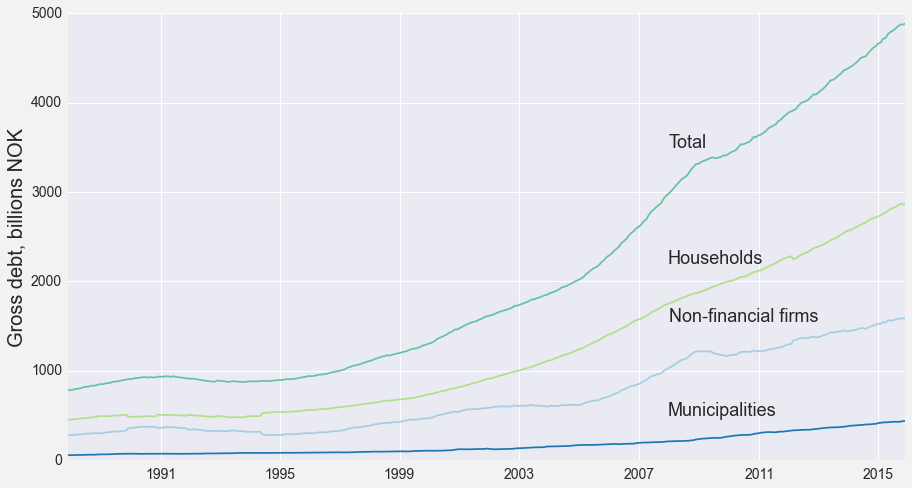

In [20]:
start = datetime.strptime('01012008', '%d%m%Y')
fig, ax = plt.subplots()
tot_by_sector = total_sources.groupby("sector")
for sect in tot_by_sector:
	ax.plot(sect[1].time, sect[1].value, label=sect[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("200801"),3500))
ax.annotate("Households", xy=(yearmonth("200801"), 2200))
ax.annotate("Non-financial firms", xy=(yearmonth("200801"), 1550))
ax.annotate("Municipalities", xy=(yearmonth("200801"), 500))
ax.set_ylabel("Gross debt, billions NOK")
fig.set_size_inches(15,8)
fig.savefig("figures/debt_by_sector.png")
plt.show()


###   household debt by source

In [21]:
debt = debt[debt.value.notnull()]
debt = debt[debt.value!=0]

household = debt[debt.sector=="Kred04 Husholdninger mv."]
household = household[household.currency =="00 I alt"]

source_inc = ["L201 Statlige l�neinstitutter",
"L202 Banker",
"L203 Kredittforetak",
"LTOT Kredittkilder i alt"]

household = household[household.credit_source.isin(source_inc)]


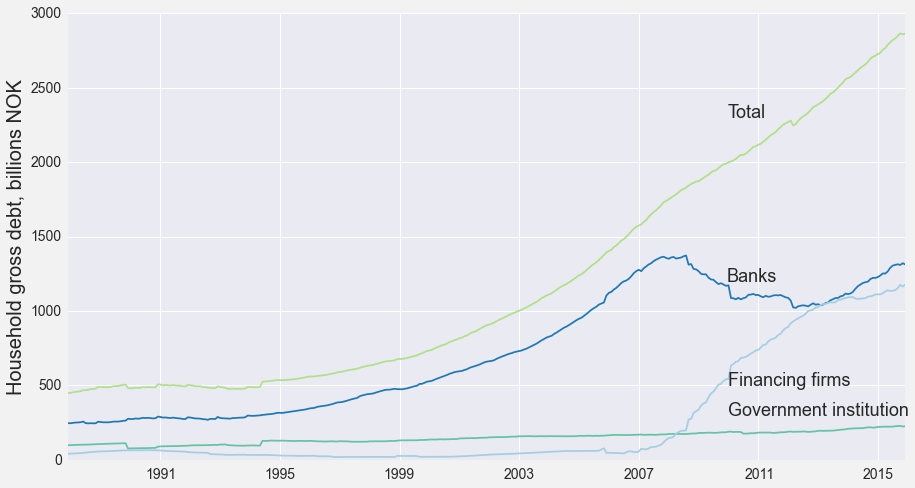

In [22]:
fig, ax = plt.subplots()
household_by_source = household.groupby("credit_source")
for source in household_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("201001"),2300))
ax.annotate("Banks", xy=(yearmonth("201001"), 1200))
ax.annotate("Financing firms", xy=(yearmonth("201001"), 500))
ax.annotate("Government institution", xy=(yearmonth("201001"), 300))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
fig.set_size_inches(15,8)
fig.savefig("figures/household_debt_by_source.png")
plt.show()

#### by currency

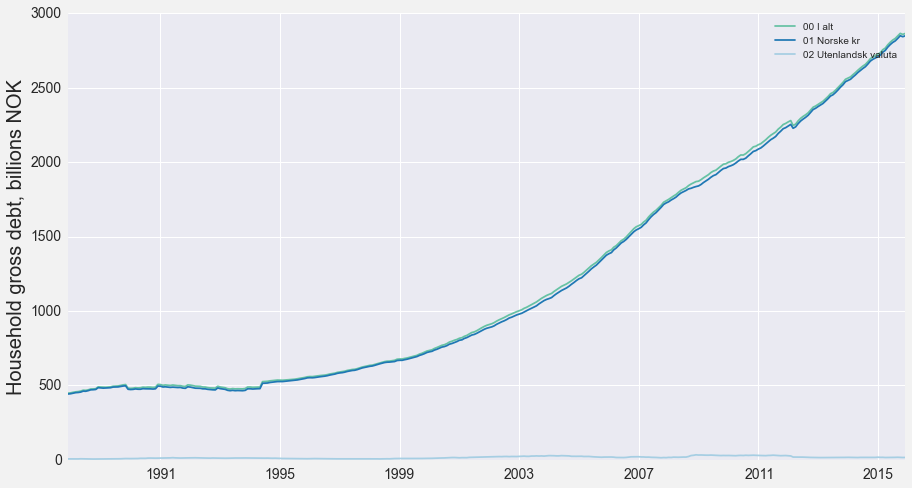

In [23]:
household = debt[debt.sector=="Kred04 Husholdninger mv."]
household = household[household.credit_source == "LTOT Kredittkilder i alt"]

fig, ax = plt.subplots()
household_by_currency = household.groupby("currency")
for currency in household_by_currency:
	ax.plot(currency[1].time, currency[1].value, label=currency[0])
ax.legend()
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Household gross debt, billions NOK")
fig.set_size_inches(15,8)
plt.show()

#### Non-financial firms

In [24]:
firms = debt[debt.sector=="Kred03 Ikke-finansielle foretak"]
firms = firms[firms.currency =="00 I alt"]

firms_inc = ["L201 Statlige l�neinstitutter",
"L202 Banker",
"L203 Kredittforetak",
"L204 Finansieringsselskaper",
"L206 Livsforsikringsselskaper",
"L207 Skadeforsikringsselskaper",
"L209 Pensjonskasser",
"L210 Obligasjonsgjeld",
"L211 Sertifikatgjeld",
"L212 Andre kilder",
"LTOT Kredittkilder i alt"]

#firms = firms[firms.credit_source.isin(source_inc)]



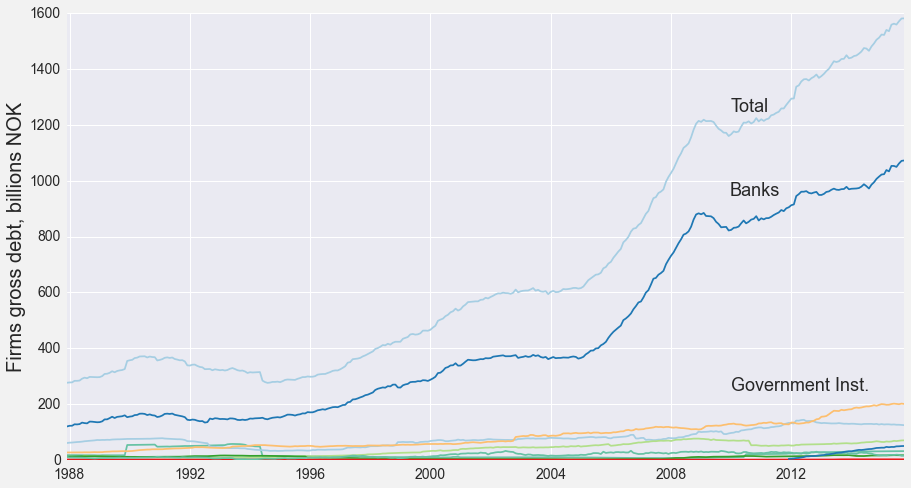

In [25]:
fig, ax = plt.subplots()
firms_by_source = firms.groupby("credit_source")
for source in firms_by_source:
	ax.plot(source[1].time, source[1].value, label=source[0])
#ax.legend()
ax.annotate("Total", xy=(yearmonth("201001"),1250))
ax.annotate("Banks", xy=(yearmonth("201001"), 950))
ax.annotate("Government Inst.", xy=(yearmonth("201001"), 250))
	#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Firms gross debt, billions NOK")
fig.set_size_inches(15,8)
fig.savefig("figures/firm_debt_by_source.png")
plt.show()

#### Interest rates

In [26]:
ir=pd.read_csv("http://www.norges-bank.no/WebDAV/stat/en/renter/v2/renter_mnd.csv")

ir["DATES"] = [datetime.strptime(d, "%b-%y") for d in ir.DATES]

ir.columns = ['date', 'folio_nom', 'res_nom', 'dlaan_nom',
	   'statskvl_3m_eff','statskvl_6m_eff', 'statskvl_9m_eff', 
	   'statskvl_12m_eff','statsobl_3y_eff', 'statsobl_5y_eff', 
	   'statsobl_10y_eff', 'nowa_rt','nowa_vl']



include = ['date','dlaan_nom', 'statskvl_3m_eff', 'statskvl_12m_eff', 'statsobl_10y_eff']
ir = ir[include]



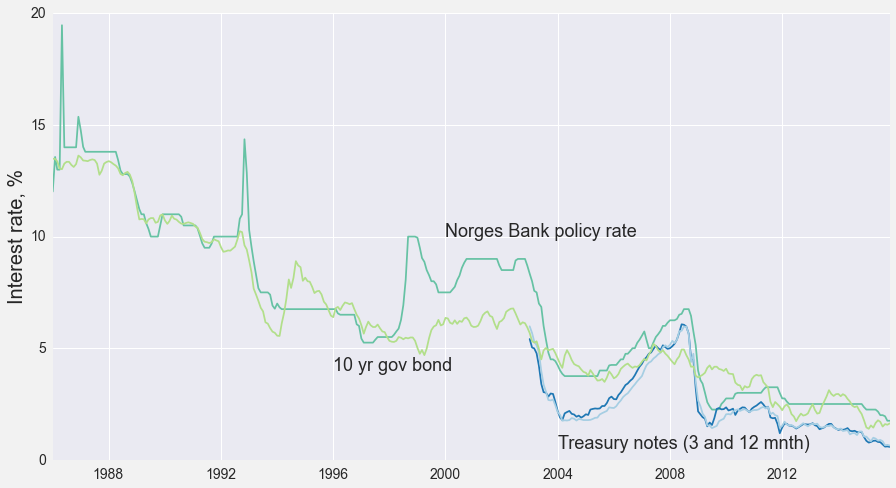

In [27]:
ir_long = pd.melt(ir, id_vars="date")
ir_long["value"][ir_long.value=="ND"] = np.nan
ir_long["value"] = ir_long.value.astype(float)

fig, ax = plt.subplots()
for r in ir_long.groupby("variable"):
	ax.plot(r[1].date, r[1].value, label=r[0])
ax.text(yearmonth("200001"), 10, "Norges Bank policy rate")
ax.text(yearmonth("200401"), .5, "Treasury notes (3 and 12 mnth)")
ax.text(yearmonth("199601"), 4, "10 yr gov bond")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/interest_rates.png")
plt.show()

#### Historical interest rates and inflation

In [28]:
long_ir = pd.ExcelFile("http://www.norges-bank.no/Upload/HMS/short_term_interest_rates/p2_c1-c7.xlsx")
real_ir = long_ir.parse('p2c7_table_7B1',header=2)
real_ir = real_ir.iloc[:-13,:]
real_ir.Year = real_ir.Year.astype(float)

rir_include = ['Year', 'Real marginal rate', 'Real deposit rate', 'Real loans rate',
       'Real bond yield']

inflation_include = ['Year', 'Inflation rate', 'Smoothed inflation rate']

inflation = real_ir[inflation_include]
real_ir = real_ir[rir_include]



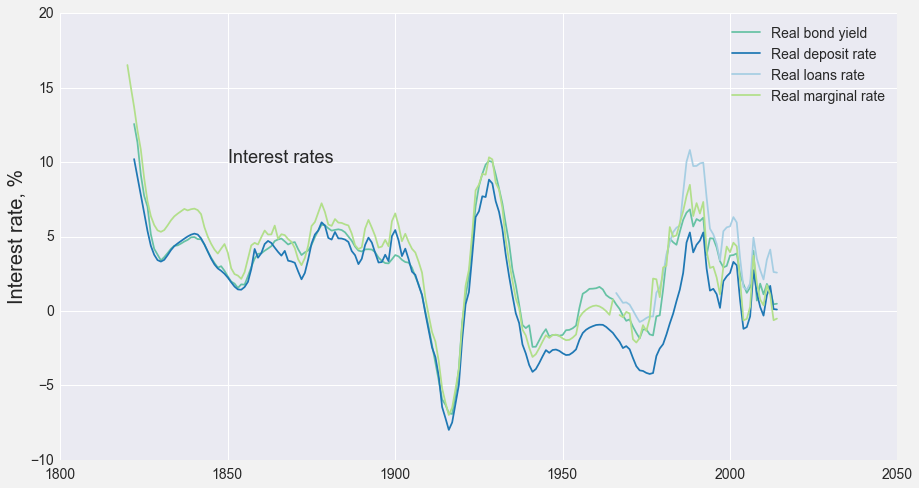

In [29]:
real_ir_long = pd.melt(real_ir, id_vars="Year")
fig, ax = plt.subplots()
for r in real_ir_long.groupby("variable"):
	ax.plot(r[1].Year, r[1].value, label=r[0])
ax.legend(fontsize=14)
ax.text(1850, 10, "Interest rates")
ax.set_ylabel("Interest rate, %")
fig.savefig("figures/ir_long.png")
plt.show()



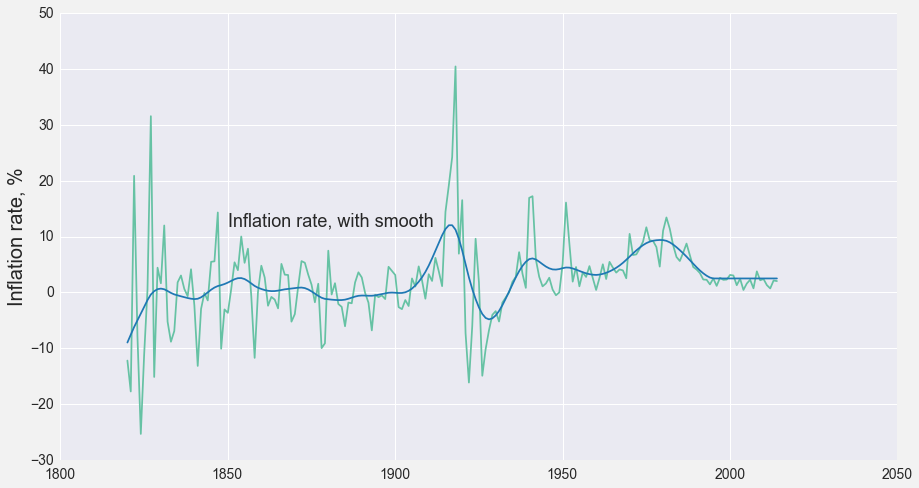

In [30]:
inflation_long = pd.melt(inflation, id_vars="Year")
fig, ax = plt.subplots()
for i in inflation_long.groupby("variable"):
	ax.plot(i[1].Year, i[1].value, label=i[0])
ax.text(1850, 12, "Inflation rate, with smooth")
ax.set_ylabel("Inflation rate, %")
# ax.legend()
fig.savefig("figures/long_inflation_rate")
plt.show()

## Oil and Gas

#### brent oil price


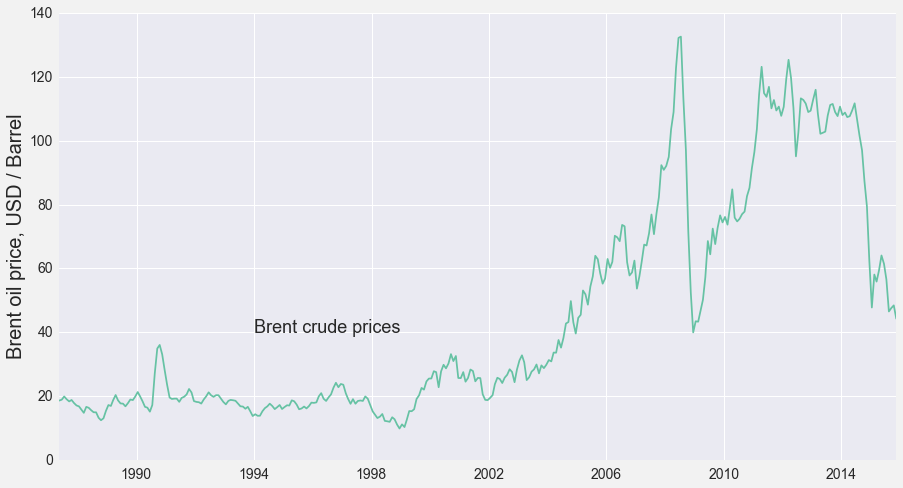

In [31]:
#prices from eia
xls = pd.ExcelFile("http://www.eia.gov/dnav/pet/hist_xls/RBRTEm.xls")
brent_prices = xls.parse('Data 1', header=2)

brent_prices.columns = ["date", "brent_price"]
brent_prices["date"] = pd.to_datetime(brent_prices.date, format="%Y-%m-%d")

fig, ax = plt.subplots()
ax.plot(brent_prices.date, brent_prices.brent_price, label="Brent Crude Price, $/Barrel")
ax.text(yearmonth("199401"), 40, "Brent crude prices")
#ax.annotate(sect[0], xy=(start, np.array(sect[1].value[0])+5 ))
ax.set_ylabel("Brent oil price, USD / Barrel")
fig.savefig("figures/brent_prices.png")
plt.show()

In [32]:
#prices from NPD
tot_prod=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_production_totalt_NCS_month__DisplayAllRows&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.56&CultureCode=nb-no")
tot_prod.columns = ['﻿prod_year', 'prod_month', 
'oil_millm3', 'gas_billsm3',
'ngl_millsm3', 'condensate_millsm3',
'oe_millsm3', 'water_millsm3']

tot_prod["date"] = pd.to_datetime(tot_prod.loc[:, '﻿prod_year'].astype(str) + tot_prod.loc[:,"prod_month"].astype(str),
	format = "%Y%m")

prod_include = ['date', 'oil_millm3', 'gas_billsm3','water_millsm3']
tot_prod = tot_prod[prod_include]

tot_prod_long = pd.melt(tot_prod, id_vars =["date"])
tot_prod_long["value"] = tot_prod_long.value.astype(float)
tot_prod_long = tot_prod_long[tot_prod_long.value!=0]

smoothed = tot_prod_long.groupby("variable")["value"].transform(smooth_series)
tot_prod_long["smoothed"] = smoothed


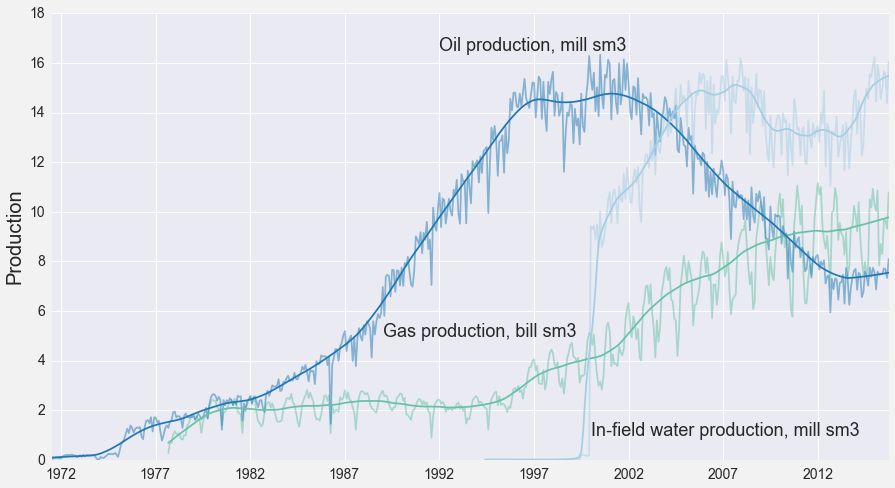

In [33]:
fig, ax = plt.subplots()
prod_by_liquid = tot_prod_long.groupby("variable")
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].value, label=liquid[0], alpha=.5)
plt.gca().set_color_cycle(None)
for liquid in prod_by_liquid:
	ax.plot(liquid[1].date, liquid[1].smoothed)
#ax.legend()
ax.text(yearmonth("199201"), 16.5, "Oil production, mill sm3")
ax.text(yearmonth("198901"), 5, "Gas production, bill sm3")
ax.text(yearmonth("200001"), 1, "In-field water production, mill sm3")
ax.set_ylabel("Production")
fig.savefig("figures/oil_gas_production.png")
plt.show()

#### Investment in oil and gas fields

In [34]:
investments=pd.read_csv("http://factpages.npd.no/ReportServer?/FactPages/TableView/field_investment_yearly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=158.37.94.112&CultureCode=en")

tot_investments = investments.groupby("prfYear")['prfInvestmentsMillNOK'].aggregate(sum)
tot_investments = tot_investments.reset_index()
tot_investments.columns = ["year", "invest_millNOK"]
tot_investments = tot_investments[tot_investments.invest_millNOK!=0]




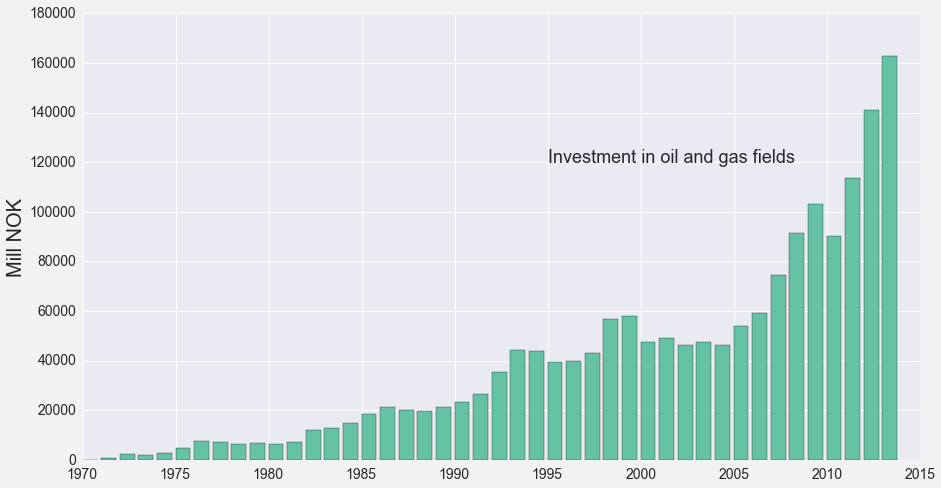

In [35]:
fig, ax = plt.subplots()
ax.bar(tot_investments.year, tot_investments.invest_millNOK, color="#66c2a4")
ax.set_ylabel("Mill NOK")
ax.text(1995, 120000, "Investment in oil and gas fields")
fig.savefig("figures/oil_investment.png", bbox_inches='tight')
plt.show()

# Wages and earnings

In [36]:
wages = pd.ExcelFile("http://www.norges-bank.no/Upload/HMS/wages_by_industry/p2c6_7.xlsx")
tot_wages = wages.parse('Table_total', header=2)
ind_wages = wages.parse('Table_6A4', header=3)

#total wages
tot_wages = tot_wages.iloc[:-12,:]
tot_wages["Year"][tot_wages.Year=="2014*"] = "2014"
tot_wages["Year"] = tot_wages.Year.astype(int)

tot_wages_long = pd.melt(tot_wages, id_vars="Year")



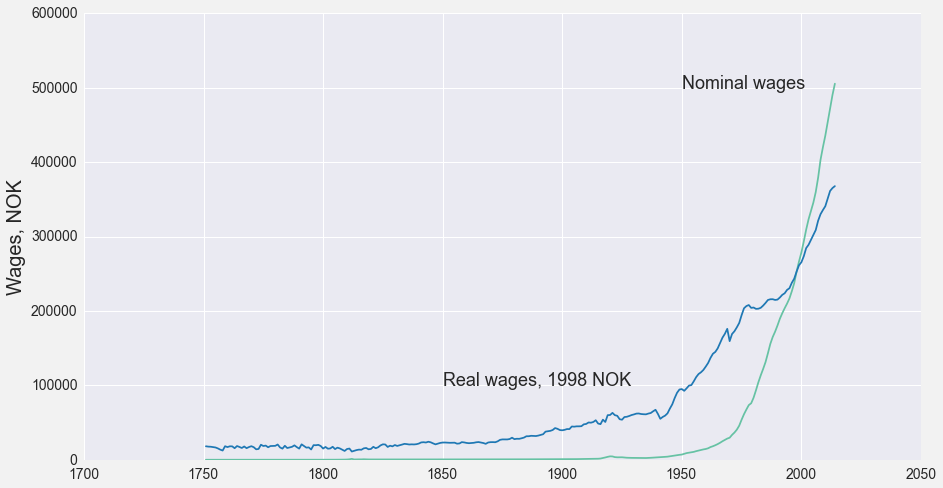

In [37]:
fig, ax = plt.subplots()
for wage in tot_wages_long.groupby("variable"):
	ax.plot(wage[1].Year, wage[1].value, label=wage[0])
ax.text(1850, 100000, "Real wages, 1998 NOK") 
ax.text(1950, 500000, "Nominal wages")
#ax.legend()
ax.set_ylabel("Wages, NOK")
fig.savefig("figures/tot_wages.png")
plt.show()

#### Demographics